# Sprint 13: Taxi Corrida Maluca

## Descrição do Projeto

A empresa Taxi Corrida Maluca coletou dados históricos sobre pedidos de táxi nos aeroportos. Para atrair mais motoristas durante o horário de pico, precisamos prever a quantidade de pedidos de táxi para a próxima hora. Construa um modelo para tal predição.

A métrica REQM no conjunto de teste não deve ser superior a 48.

## 1. INICIALIZAÇÃO

### 1.1. Importando Bibliotecas

In [1]:
# Basics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Decompose
from statsmodels.tsa.seasonal import seasonal_decompose

# Split dataset
from sklearn.model_selection import train_test_split

# Pre-processor
from sklearn.preprocessing import StandardScaler

# Pipeline
from sklearn.pipeline import Pipeline

# GridSearch
from sklearn.model_selection import GridSearchCV

# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

# Metrics
from sklearn.metrics import make_scorer, mean_squared_error

# Adicionais
import math
import time

# Warnings
import warnings
warnings.filterwarnings("ignore")

### 1.2. Carregando Dataset

In [2]:
# Carregando o dataset

# Local Path
local_taxi_path = "taxi.csv"

# Cloud Path
taxi_path = "./datasets/taxi.csv"

try:
    df = pd.read_csv(local_taxi_path, sep=",", index_col=[0], parse_dates=[0])

except FileNotFoundError:
    print(
        f"O arquivo CSV não foi encontrado em {local_taxi_path}. Tentando o caminho {taxi_path}..."
    )

    try:
        df = pd.read_csv(taxi_path, sep=",", index_col=[0], parse_dates=[0])

    except FileNotFoundError:
        print(
            f"O arquivo CSV não foi encontrado em {local_taxi_path}. Nenhum arquivo encontrado..."
        )

O arquivo CSV não foi encontrado em taxi.csv. Tentando o caminho ./datasets/taxi.csv...


In [3]:
# Checando se DataFrame foi importado
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


### 1.3. Analisando os Dados

In [4]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
# checando se tem dados nulos
df.isna().sum()

num_orders    0
dtype: int64

In [6]:
# Ordenando o dataset e separando por Hora
df.sort_index(inplace=True)
df = df.resample("1H").sum()

In [7]:
# Checando os valores
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [8]:
# verificar se os valores da série são crescentes ou não
if df.index.is_monotonic_increasing:
    print("O index está em ordem crescente.")
else:
    print("O index não está em ordem crescente.")

O index está em ordem crescente.


In [9]:
# Visualizando os dados


def trend_seasonality(df):
    """
    Construção do gráfico para plotar as tendências, Sazonalidades e Resíduos do dataframe.
    """

    # Decomposed data
    decomposed = seasonal_decompose(df)

    # Criando o plot
    fig = plt.figure(figsize=(13, 8))
    fig.suptitle("Decomposed Data")

    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title("Tendência")
    plt.xlabel("")

    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title("Sazonalidade")
    plt.xlabel("")

    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title("Resíduos")

    plt.tight_layout()

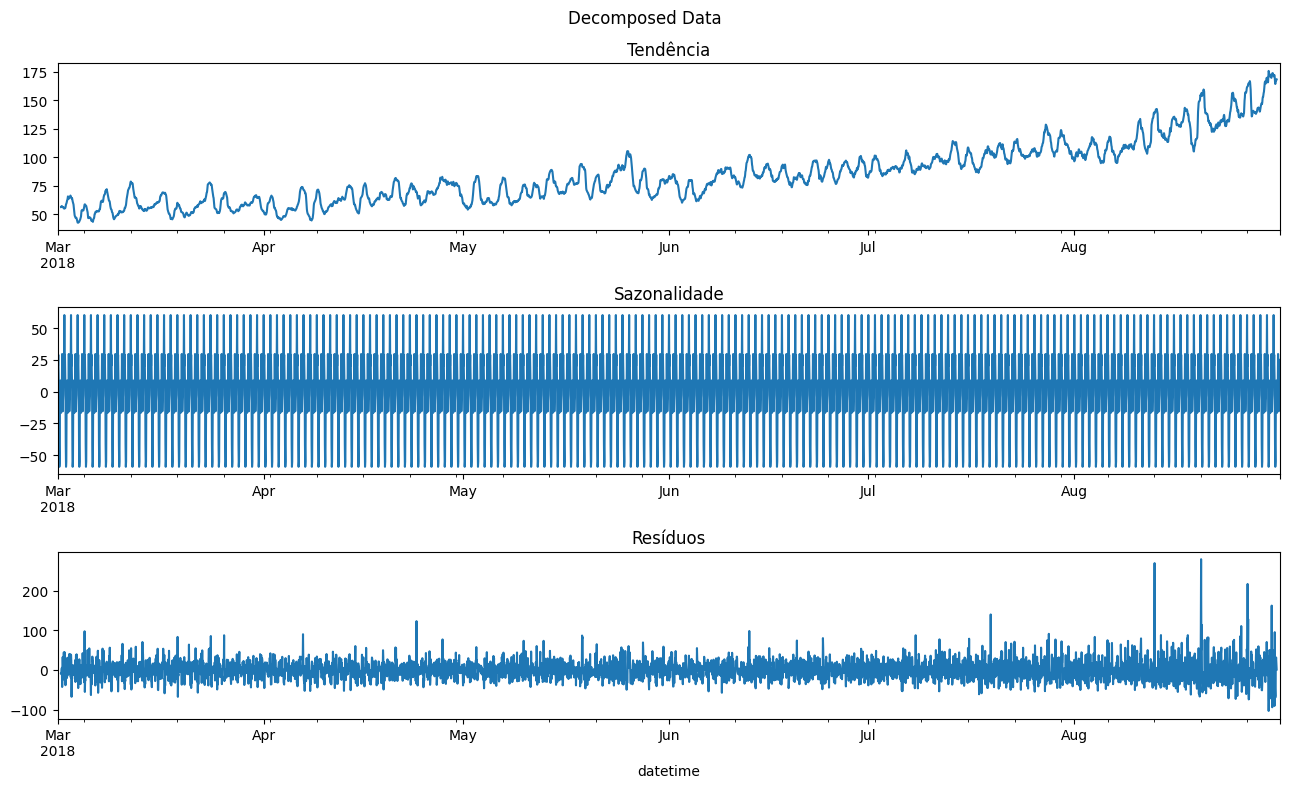

In [10]:
# Decompondo os dados e plotando a Tendência, Sazonalidade e Resíduos
trend_seasonality(df)

- Podemos perceber, pelos gráficos acima, que há uma leve tendência nos pedidos, que aumentam mais a partir do mês de Julho. Isso deve ocorrer devido à sazonalidade, pois com mais viagens sendo solicitadas durante os meses de inverno.

- Como os dados cobrem apenas datas de 2018, não se pode determinar se é uma tendência sazonal ou uma tendência positiva real.

- No gráfico de Sazonalidade, pode ser visto que há uma oscilação constante nos pedidos, que variam cerca de -55 a 55.

- Dado que parece haver uma tendência nos dados, pode-se concluir que a série temporal é não estacionária, o que nos impediria de prever com precisão os valores futuros dos pedidos de táxi.

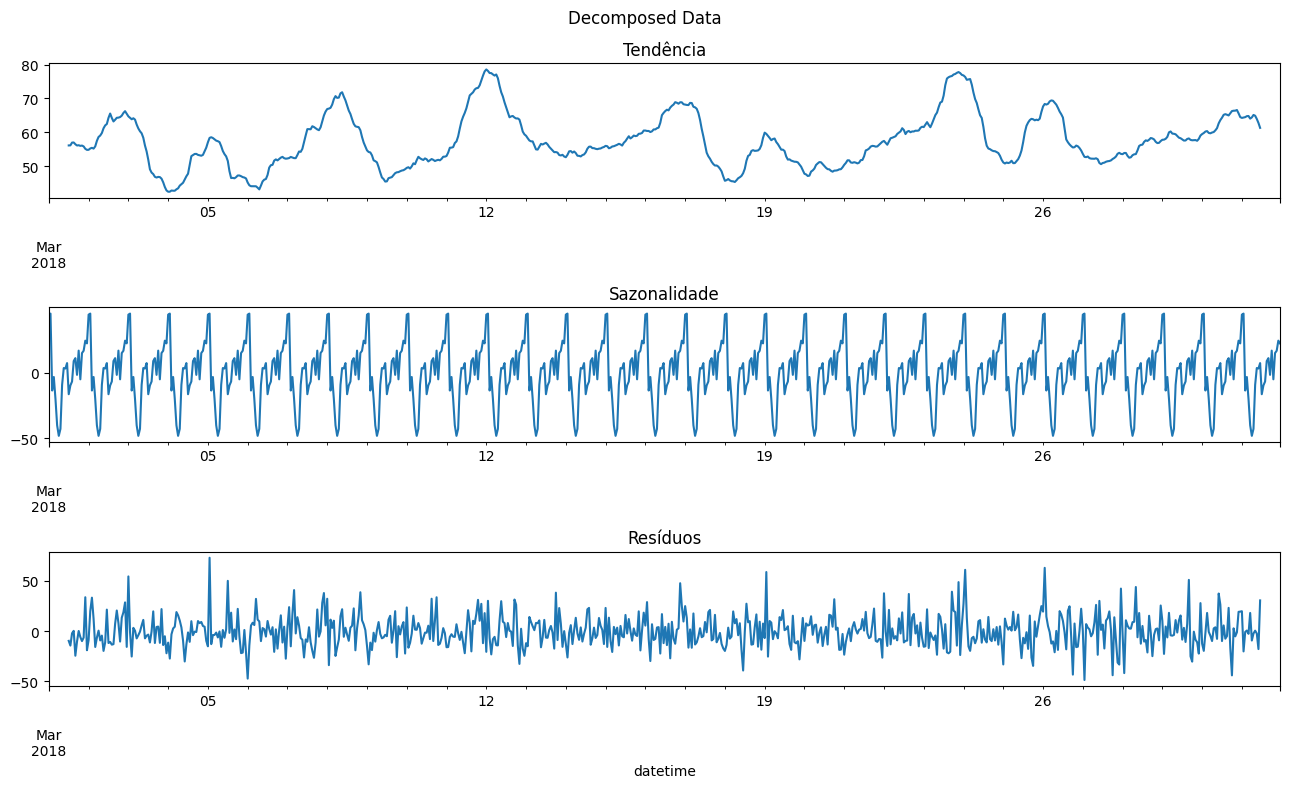

In [11]:
# Olhando para dentro de 1 Mês
trend_seasonality(df.loc["2018-03"])

- Com o conjunto de dados dentro de 1 mês, é difícil ver uma tendência clara, como no conjunto de dados completo.

- No gráfico de Sazonalidade, mostra que os pedidos de táxis aumentam rapidamente durante as primeiras horas da manhã e ultimas horas da tarde. No intervalo entre essas horas, tendem a oscilar bastante.

- Por fim, a variação dos resíduos parece ser semelhantes para o conjunto de dados completo e para o período de 1 mês.

### 1.4. Checando Estacionariedade

Uma série temporal estacionária é aquela cujas propriedades não dependem dos momentos em que a série é observada. Por exemplo, se o valor de uma variável estiver correlacionado com sazonalidade ou tendências, então a série é não estacionária, pois tanto as sazonalidades quanto as tendências afetam o valor da série em momentos diferentes. 

Para construir um modelo que preveja valores com base em uma série temporal, a série deve ser estacionária.

In [12]:
# Função para criar plot do dataframe com média e desvio padrão


def check_stationary(df, mean_window, std_window):
    """
    Esta função plota os valores de uma série temporal, juntamente com uma média móvel e desvio padrão.

    Os argumentos incluem:
    - df: Série a ser plotada.
    - mean_window: O tamanho da janela da média móvel.
    - sd_window: O tamanho da janela do desvio padrão móvel.
    """

    # Fazendo a cópia do dataframe original
    df_copy = df.copy()

    df_copy["mean"] = df_copy["num_orders"].rolling(mean_window).mean()
    df_copy["std"] = df_copy["num_orders"].rolling(std_window).std()

    # Criando o plot
    fig = plt.figure(figsize=(15, 7))
    fig.suptitle("Dados de Série Temporal com Média Móvel e Desvio Padrão Móvel ")

    plt.ylabel("Número de Ordens")
    plt.xlabel("Data de Observação")
    plt.legend()

    plt.plot(df_copy.index, df_copy["num_orders"], label="Original Data")
    plt.plot(df_copy.index, df_copy["mean"], label=f"Média Móvel ({mean_window})")
    plt.plot(df_copy.index, df_copy["std"], label=f"Desvio Padrão Móvel ({std_window})")

    plt.legend()
    plt.show()

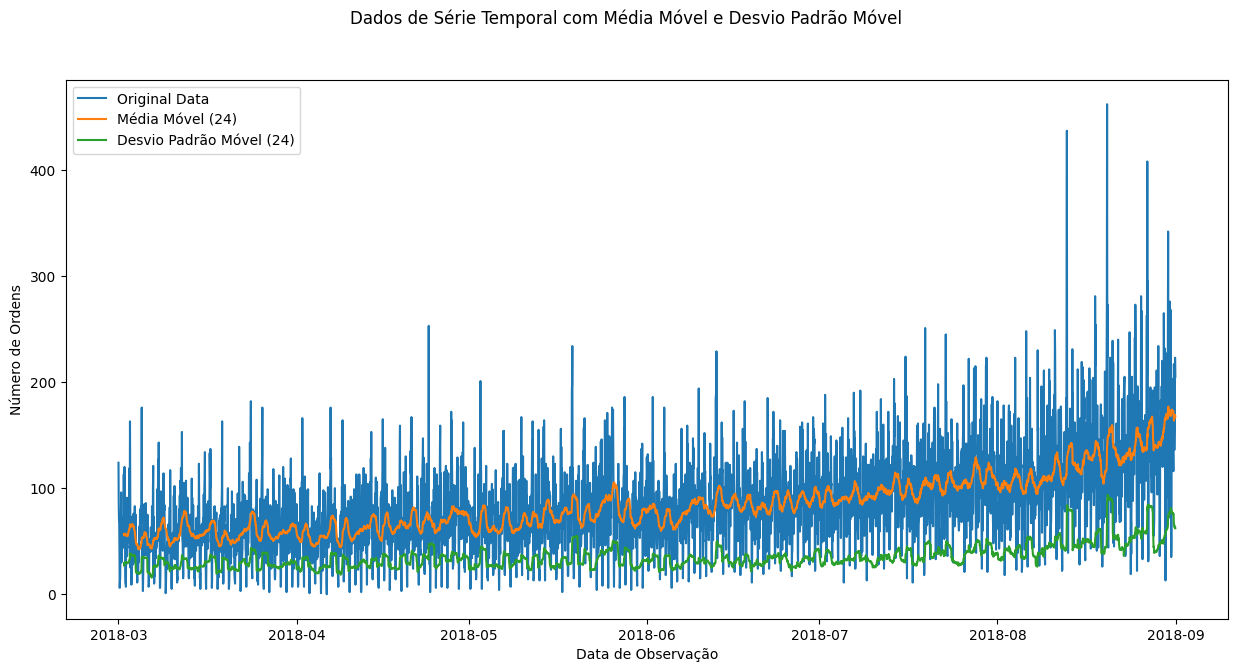

In [13]:
# Plotando o grafico com as médias e desvio padrão igual a 24, para representar 1 dia
check_stationary(df, 24, 24)

- Pode-ser notado que as médias e os desvios padrões mudam durante o período, ou seja, o processo estocástico é **não estacionário**. 

- Para prosseguir, devemos transformar os dodos em um processo estocástico estacionário.

### 1.5. Transformando em Série Estacionária

In [14]:
# Criando uma nova serie com a diferença de 1 shift
df_diff = df - df.shift(24)

# Drop NaN na primeira linha
df_diff.dropna(inplace=True)

# Display dos resultados
df_diff.head()

,num_orders
datetime,
2018-03-02 00:00:00,-34.0
2018-03-02 01:00:00,35.0
2018-03-02 02:00:00,4.0
2018-03-02 03:00:00,-2.0
2018-03-02 04:00:00,-23.0


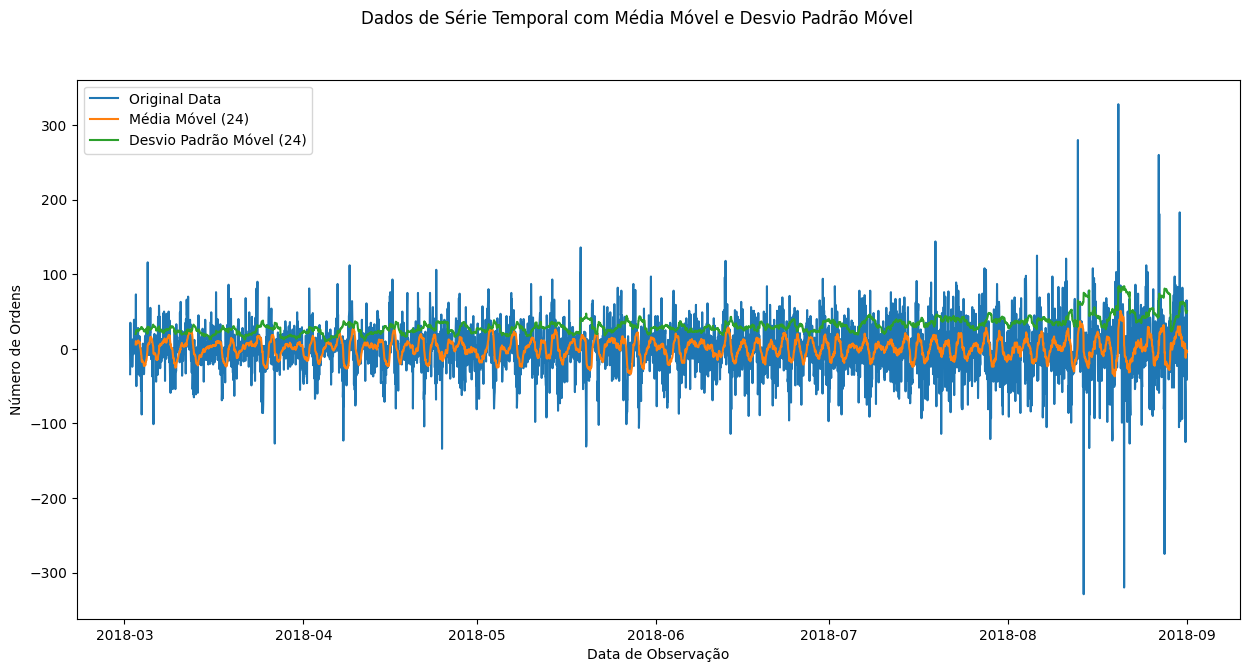

In [15]:
# Fazendo o plot do df_diff
check_stationary(df_diff, 24, 24)

- Agora podemos observar que a tendência do final do período não está mais presente no novo dataframe com as diferenças. Ou seja, enquanto há alguma oscilação na média móvel e no desvio padrão, eles oscilam aproximadamente em torno do mesmo valor.

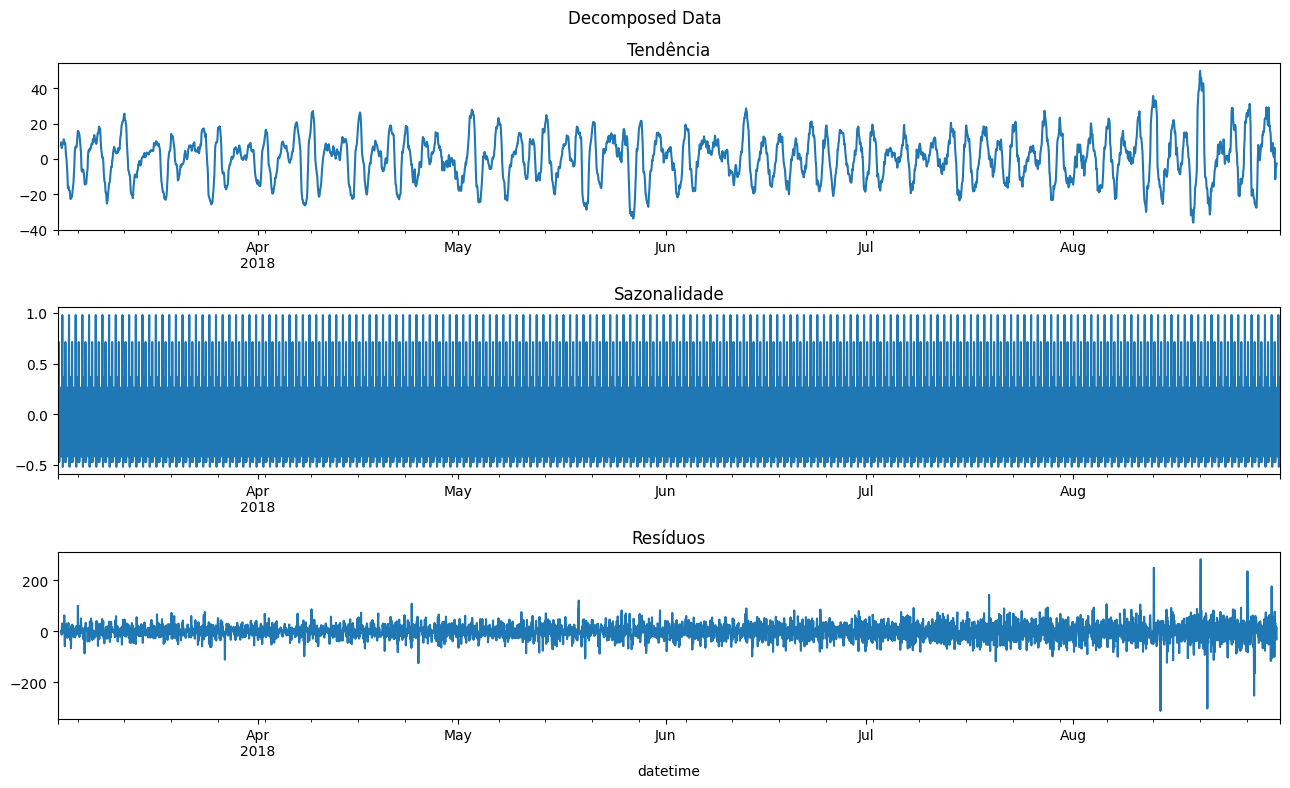

In [16]:
# Checando tendência, Sazonalidade e Resíduos do df_diff
trend_seasonality(df_diff)

- A partir desses gráficos, podemos ver que reduzimos significativamente os efeitos da tendência e sazonalidade em nossa série.

- Os valores da tendência parecem oscilar em torno de 0, e a tendência geral não parece aumentar nem diminuir.

- Em relação à sazonalidade, a faixa de valores está entre -0.5 e 1, ou seja, não parece ser muito significante.

## 2. DIVISÃO DO DATASET

In [17]:
# Criando as features
def make_features(df, max_lags, rolling_mean_size, rolling_std):

    # Criando features de calendário
    df["hour"] = df.index.hour
    df["day"] = df.index.day
    df["dayofweek"] = df.index.dayofweek
    df["month"] = df.index.month

    # Criando features de defasagem
    for lag in range(1, max_lags + 1):
        df[f"lag_{lag}"] = df["num_orders"].shift(lag)

    # Criando features móveis
    df["rolling_mean"] = df["num_orders"].shift().rolling(rolling_mean_size).mean()
    df["rolling_std"] = df["num_orders"].shift().rolling(rolling_std).std()

In [18]:
# Criando as features no dataframe df_diff
make_features(df_diff, 24, 24, 24)

# display df_diff
display(df_diff.head())

,num_orders,hour,day,dayofweek,month,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean,rolling_std
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,-34.0,0,2,4,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-02 01:00:00,35.0,1,2,4,3,-34.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-02 02:00:00,4.0,2,2,4,3,35.0,-34.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-02 03:00:00,-2.0,3,2,4,3,4.0,35.0,-34.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-02 04:00:00,-23.0,4,2,4,3,-2.0,4.0,35.0,-34.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# Dividindo o dataset em treinamento (90%) e teste (10%)
train, test = train_test_split(
    df_diff, test_size=0.1, random_state=12345, shuffle=False
)

# Dividindo o dataset em treinamento (75%) e validação (25%)
train, valid = train_test_split(
    train, train_size=0.75, random_state=12345, shuffle=False
)

# Drop NaN
train.dropna(inplace=True)

In [20]:
# Observando o número de observações de cada conjunto de dados
display(
    pd.DataFrame(
        data=[len(df_diff), len(train), len(valid), len(test)],
        index=["Original", "Train", "Validate", "Test"],
        columns=["num_observtions"],
    )
)

,num_observtions
Original,4392
Train,2940
Validate,988
Test,440


In [21]:
# definindo variáveis em X (features) e y (target)

# Conjunto de Treinamento:
features_train = train.drop(["num_orders"], axis=1)
target_train = train["num_orders"]

# Conjunto de Validação:
features_valid = valid.drop(["num_orders"], axis=1)
target_valid = valid["num_orders"]

# Conjunto de Teste:
features_test = test.drop(["num_orders"], axis=1)
target_test = test["num_orders"]

In [22]:
# Shapes

# Treinamento:
print(f"Shape Train: ", train.shape)

# Validação:
print(f"Shape valid: ", valid.shape)

# Teste:
print(f"Shape test: ", test.shape)

Shape Train:  (2940, 31)
Shape valid:  (988, 31)
Shape test:  (440, 31)


## 3. MODELOS DE REGRESSÃO

### 3.1. Definindo Função Score

In [23]:
# Criando função para retornar o RMSE


def rmse_score(target, prediction):
    return round(math.sqrt(mean_squared_error(target, prediction)), 2)


# Criando o scorer do rmse para o GridSearchCV
rmse = make_scorer(rmse_score, greater_is_better=False)

### 3.2. Criando Classes para os Modelos

In [24]:
# Criando classe para encontrar o melhor modelo enquanto usa o pipeline para transformar os dados
class create_model:

    # Inicializador do modelo com as variáveis
    def __init__(self, model, params, name):
        self.model = model
        self.params = params
        self.name = name
        self.rmse = None
        self.train_score = None
        self.valid_score = None
        self.best_params = None
        self.best_rate = None
        self.final_test_score = None

    # Função para treinar e validar o modelo
    def score_model(
        self,
        features_train=None,
        target_train=None,
        features_valid=None,
        target_valid=None,
        features_test=None,
        target_test=None,
        scale=False,
    ):

        # Cria pipeline com o scaler caso o modelo for non-tree based
        if scale == True:
            pipeline = Pipeline(
                steps=[["scale", StandardScaler()], ["classifier", self.model]]
            )

        else:
            pipeline = Pipeline(steps=[["classifier", self.model]])

        # Usando gridsearch para procurar melhores parâmetros
        grid_search = GridSearchCV(
            estimator=pipeline, param_grid=self.params, scoring=rmse, cv=5, verbose=0
        )

        # Fit melhor modelo e obtendo os resultados
        grid_search.fit(features_train, target_train)
        self.rmse = -1 * grid_search.best_score_
        self.train_score = -1 * grid_search.score(features_train, target_train)
        self.valid_score = -1 * grid_search.score(features_valid, target_valid)
        self.best_params = grid_search.best_params_

In [25]:
# Dicionário para armazenar resultados
dict_training_scores = {}
dict_valid_scores = {}
dict_test_scores = {}
dict_time = {}
dict_best_params = {}

### 3.3.1. Linear Regression (BaseLine)

In [26]:
%%time

# Start timer para salvar o tempo de execução na variável
t0 = time.time()

# Treino e Test do modelo LinearRegression
pipe_LR = create_model(LinearRegression(), {}, "Linear Regression")

# Não é preciso escalar
pipe_LR.score_model(
    features_train=features_train,
    target_train=target_train,
    features_valid=features_valid,
    target_valid=target_valid,
    features_test=features_test,
    target_test=target_test,
    scale=True,
)

# stop timer para salvar o tempo de execução
t1 = time.time()

# Obtendo os scores do modelo
dict_training_scores[pipe_LR.name] = round(pipe_LR.train_score, 2)
dict_valid_scores[pipe_LR.name] = round(pipe_LR.valid_score, 2)
dict_test_scores[pipe_LR.name] = round(pipe_LR.rmse, 2)
dict_time[pipe_LR.name] = round(t1 - t0, 2)
dict_best_params[pipe_LR.name] = pipe_LR.best_params

CPU times: total: 266 ms
Wall time: 84.3 ms


### 3.3.2. Decision Tree Regressor

In [27]:
%%time

# Start timer para salvar o tempo de execução na variável
t0 = time.time()

# Treino e Test do modelo DecisionTreeRegressor
pipe_DTR = create_model(
    DecisionTreeRegressor(random_state=12345),
    {"classifier__max_depth": range(1, 51, 10)},
    "Decision Tree Regressor",
)

# Não é preciso escalar, pois o algoritmo do modelo é baseado na distância
pipe_DTR.score_model(
    features_train=features_train,
    target_train=target_train,
    features_valid=features_valid,
    target_valid=target_valid,
    features_test=features_test,
    target_test=target_test,
    scale=False,
)

# stop timer para salvar o tempo de execução
t1 = time.time()

# Obtendo os scores do modelo
dict_training_scores[pipe_DTR.name] = round(pipe_DTR.train_score, 2)
dict_valid_scores[pipe_DTR.name] = round(pipe_DTR.valid_score, 2)
dict_test_scores[pipe_DTR.name] = round(pipe_DTR.rmse, 2)
dict_time[pipe_DTR.name] = round(t1 - t0, 2)
dict_best_params[pipe_DTR.name] = pipe_DTR.best_params

CPU times: total: 594 ms
Wall time: 1.06 s


### 3.3.3. Random Forest Regressor

In [28]:
%%time

# Start timer para salvar o tempo de execução na variável
t0 = time.time()

# Treino e Test do modelo DecisionTreeRegressor
pipe_RFR = create_model(
    RandomForestRegressor(random_state=12345),
    {
        "classifier__n_estimators": range(1, 101, 10),
        "classifier__max_depth": range(1, 16, 5),
    },
    "Random Forest Regressor",
)

# Não é preciso escalar, pois o algoritmo do modelo é baseado na distância
pipe_RFR.score_model(
    features_train=features_train,
    target_train=target_train,
    features_valid=features_valid,
    target_valid=target_valid,
    features_test=features_test,
    target_test=target_test,
    scale=False,
)

# stop timer para salvar o tempo de execução
t1 = time.time()

# Obtendo os scores do modelo
dict_training_scores[pipe_RFR.name] = round(pipe_RFR.train_score, 2)
dict_valid_scores[pipe_RFR.name] = round(pipe_RFR.valid_score, 2)
dict_test_scores[pipe_RFR.name] = round(pipe_RFR.rmse, 2)
dict_time[pipe_RFR.name] = round(t1 - t0, 2)
dict_best_params[pipe_RFR.name] = pipe_RFR.best_params

CPU times: total: 1min 7s
Wall time: 1min 23s


### 3.3.4. Cat Boost Regressor

In [29]:
%%time

# Start timer para salvar o tempo de execução na variável
t0 = time.time()

# Treino e Test do modelo DecisionTreeRegressor
pipe_CBR = create_model(
    CatBoostRegressor(random_state=12345, verbose=False),
    {
        "classifier__depth": [4, 6, 8],
        "classifier__learning_rate": [0.01, 0.05, 0.1],
        "classifier__iterations": [100, 200, 300],
    },
    "CatBoost Regressor",
)

# Não é preciso escalar, pois o algoritmo do modelo é baseado na distância
pipe_CBR.score_model(
    features_train=features_train,
    target_train=target_train,
    features_valid=features_valid,
    target_valid=target_valid,
    features_test=features_test,
    target_test=target_test,
    scale=False,
)

# stop timer para salvar o tempo de execução
t1 = time.time()

# Obtendo os scores do modelo
dict_training_scores[pipe_CBR.name] = round(pipe_CBR.train_score, 2)
dict_valid_scores[pipe_CBR.name] = round(pipe_CBR.valid_score, 2)
dict_test_scores[pipe_CBR.name] = round(pipe_CBR.rmse, 2)
dict_time[pipe_CBR.name] = round(t1 - t0, 2)
dict_best_params[pipe_CBR.name] = pipe_CBR.best_params

CPU times: total: 2min 54s
Wall time: 1min 11s


### 3.3.5. XGB Regressor

In [30]:
%%time

# Start timer para salvar o tempo de execução na variável
t0 = time.time()

# Treino e Test do modelo DecisionTreeRegressor
pipe_XGBR = create_model(
    XGBRegressor(random_state=12345, verbose=False),
    {
        "classifier__max_depth": [3, 5, 7],
        "classifier__n_estimators": range(50, 400, 50),
        "classifier__learning_rate": [0.001, 0.01, 0.1],
    },
    "XGB Regressor",
)

# Não é preciso escalar, pois o algoritmo do modelo é baseado na distância
pipe_XGBR.score_model(
    features_train=features_train,
    target_train=target_train,
    features_valid=features_valid,
    target_valid=target_valid,
    features_test=features_test,
    target_test=target_test,
    scale=False,
)

# stop timer para salvar o tempo de execução
t1 = time.time()

# Obtendo os scores do modelo
dict_training_scores[pipe_CBR.name] = round(pipe_CBR.train_score, 2)
dict_valid_scores[pipe_CBR.name] = round(pipe_CBR.valid_score, 2)
dict_test_scores[pipe_CBR.name] = round(pipe_CBR.rmse, 2)
dict_time[pipe_CBR.name] = round(t1 - t0, 2)
dict_best_params[pipe_CBR.name] = pipe_CBR.best_params

CPU times: total: 13min 48s
Wall time: 1min 5s


### 3.3.6. LGBM Regressor

In [31]:
%%time

# Start timer para salvar o tempo de execução na variável
t0 = time.time()

# Treino e Test do modelo DecisionTreeRegressor
pipe_LGBMR = create_model(
    LGBMRegressor(random_state=12345, verbose=-1),
    {
        "classifier__max_depth": [3, 5, 7],
        "classifier__n_estimators": range(50, 400, 50),
        "classifier__learning_rate": [0.001, 0.01, 0.1],
    },
    "LGBM Regressor",
)

# Não é preciso escalar, pois o algoritmo do modelo é baseado na distância
pipe_LGBMR.score_model(
    features_train=features_train,
    target_train=target_train,
    features_valid=features_valid,
    target_valid=target_valid,
    features_test=features_test,
    target_test=target_test,
    scale=False,
)

# stop timer para salvar o tempo de execução
t1 = time.time()

# Obtendo os scores do modelo
dict_training_scores[pipe_LGBMR.name] = round(pipe_LGBMR.train_score, 2)
dict_valid_scores[pipe_LGBMR.name] = round(pipe_LGBMR.valid_score, 2)
dict_test_scores[pipe_LGBMR.name] = round(pipe_LGBMR.rmse, 2)
dict_time[pipe_LGBMR.name] = round(t1 - t0, 2)
dict_best_params[pipe_LGBMR.name] = pipe_LGBMR.best_params

  File "c:\Users\pedro\Desktop\Pedro\code\portfolio_projetos\taxi\env\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


CPU times: total: 4min 34s
Wall time: 25.3 s


## 4. ANÁLISE DOS MODELOS

In [32]:
# Criação de DataFrame dos scores
mydicts = [
    dict_training_scores,
    dict_valid_scores,
    dict_test_scores,
    dict_time,
    dict_best_params,
]
final_scores = pd.concat([pd.Series(d) for d in mydicts], axis=1)
final_scores.columns = [
    "RMSE Train",
    "RMSE Valid",
    "RMSE Test",
    "Time (s)",
    "Best Params",
]
final_scores.sort_values("RMSE Test", ascending=True, inplace=True)

# Display final scores.
display(final_scores)

,RMSE Train,RMSE Valid,RMSE Test,Time (s),Best Params
CatBoost Regressor,19.01,30.46,22.20,65.65,"{'classifier__depth': 6, 'classifier__iteratio..."
LGBM Regressor,19.41,30.56,22.40,25.30,"{'classifier__learning_rate': 0.1, 'classifier..."
Random Forest Regressor,13.36,30.79,22.48,83.97,"{'classifier__max_depth': 11, 'classifier__n_e..."
Linear Regression,22.65,31.35,22.88,0.08,{}
Decision Tree Regressor,26.19,34.29,26.39,1.06,{'classifier__max_depth': 1}


In [33]:
# Mostrando os melhores parametros para cada modelo
dict_best_params

{'Linear Regression': {},
 'Decision Tree Regressor': {'classifier__max_depth': 1},
 'Random Forest Regressor': {'classifier__max_depth': 11,
  'classifier__n_estimators': 91},
 'CatBoost Regressor': {'classifier__depth': 6,
  'classifier__iterations': 200,
  'classifier__learning_rate': 0.05},
 'LGBM Regressor': {'classifier__learning_rate': 0.1,
  'classifier__max_depth': 3,
  'classifier__n_estimators': 100}}

Vamos analisar os resultados:

1. **CatBoost Regressor:**

- RMSE de Treino: 19.01
- RMSE de Validação: 30.46
- RMSE de Teste: 22.20
- Tempo de Execução: 86.24 segundos
- Melhores Parâmetros: {'classifier__depth': 6, 'classifier__iterations': 200, 'classifier__learning_rate': 0.05}

Este modelo possui o melhor desempenho geral, com um RMSE de teste de 22.20. Os melhores parâmetros incluem uma profundidade de 6 para as árvores, 200 iterações e uma taxa de aprendizado de 0.05.

2. **LGBM Regressor:**

- RMSE de Treino: 19.41
- RMSE de Validação: 30.56
- RMSE de Teste: 22.40
- Tempo de Execução: 29.92 segundos
- Melhores Parâmetros: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}

Assim como o CatBoost, o LGBM Regressor também tem um bom desempenho, com um RMSE de teste de 22.40. Os melhores parâmetros incluem uma taxa de aprendizado de 0.1, profundidade máxima de 3 para as árvores e 100 estimadores.

3. **Random Forest Regressor:**

- RMSE de Treino: 13.36
- RMSE de Validação: 30.79
- RMSE de Teste: 22.48
- Tempo de Execução: 85.62 segundos
- Melhores Parâmetros: {'classifier__max_depth': 11, 'classifier__n_estimators': 91}

Este modelo apresenta um RMSE de teste de 22.48, um pouco maior do que os modelos anteriores. Os melhores parâmetros incluem uma profundidade máxima de árvore de 11 e 91 estimadores.

4. **Linear Regression (Base Line):**

- RMSE de Treino: 22.65
- RMSE de Validação: 31.35
- RMSE de Teste: 22.88
- Tempo de Execução: 0.08 segundos
- Melhores Parâmetros: {}

Este modelo tem um desempenho inferior em comparação com os modelos baseados em árvore, com um RMSE de teste de 22.88. Como é um modelo linear, não há parâmetros específicos a serem ajustados.

5. **Decision Tree Regressor:**

- RMSE de Treino: 26.19
- RMSE de Validação: 34.29
- RMSE de Teste: 26.39
- Tempo de Execução: 1.17 segundos
- Melhores Parâmetros: {'classifier__max_depth': 1}

Este modelo tem o pior desempenho, com um RMSE de teste de 26.39, ficando pior que o modelo de base line (Linear Regression). Os melhores parâmetros indicam uma profundidade máxima de árvore de 1, sugerindo um modelo muito simples.

## **Conclusão:**

- Os modelos baseados em árvore (CatBoost, LGBM e Random Forest) apresentam os melhores desempenhos, com RMSE de teste em torno de 22.2 e 22.5.

- O modelo Linear Regression tem um desempenho inferior, indicando que a relação entre os recursos e o alvo pode não ser linear.

- O Decision Tree Regressor tem o pior desempenho, sugerindo que um único modelo de árvore de decisão pode ser muito simplista para este problema.


## **Recomendação:**

Com base nos resultados, os modelos CatBoost, LGBM e Random Forest são as escolhas preferenciais para prever o alvo neste conjunto de dados, dada a sua melhor capacidade de generalização.